In [12]:
import random 
import math 
random.seed(42)
array = [random.randint(0,1) for _ in range(1_00_000)]
array = ''.join([str(x) for x in array])

In [3]:
def prefixSum(arr):
    n = len(arr)
    rank = [0]*n
    for i in range(n):
        rank[i] = rank[i-1] + int(arr[i])
    return rank

In [182]:
with open("Homo_sapiens.GRCh38.dna.chromosome.22.fa") as f:
    f.readline()          # skip header
    genome = f.read().replace("\n", "")


In [185]:
## wavelet tree 
strValue = {'A':1,'C':2,'G':3,'T':4,'N':5}

class Node:
    def __init__(self,key=None,value=None):
        self.key = key
        self.value = value 
        self.left = None
        self.right = None
        self.first = None 
        self.second = None 
        self.third = None
        self.bitArray = None

nodes = []
for key,value in strValue.items():
    nodes.append(Node(value,key))

while len(nodes) > 1: 
    new_level = []
    for i in range(0,len(nodes),2):
        if i+1 < len(nodes):
            left,right = nodes[i],nodes[i+1]
            parent = Node()
            parent.left = left 
            parent.right = right
            temp = left
            while temp.right is not None:
                temp = temp.right

            parent.key = temp.key 
            new_level.append(parent)
        else:
            new_level.append(nodes[i])
    nodes = new_level

root = nodes[0]

In [156]:
def createBlocks(array):
    first = []
    second = []
    l = math.ceil(math.log2(len(array))/2)**2
    k = math.ceil(math.log2(len(array))/2)
    ranked_array = prefixSum(array)
    for i in range(0,len(array),l):
        first.append(ranked_array[i])

    for j in range(0,len(array),k):
        i_l,j_l = divmod(j,l)
        if j_l != 0:        
            second.append(ranked_array[j] - ranked_array[i_l*l])
        else:
            second.append(0)

    from itertools import product
    third = {}
    for r in list(product(['0','1'],repeat=k-1)):
        lkp = ''.join(r)
        third[int(lkp,2)] =  prefixSum(lkp)
        
    return first,second,third,array

def rank(first,second,third,B,i):
    rank_l = 0 
    if i < 0:
        return 0
    n = len(B)
    l = math.ceil(math.log2(n)/2)**2
    k = math.ceil(math.log2(n)/2)
    i_l,j_l = divmod(i,l)
    i_k,j_k = divmod(i,k)
    rank_l += first[i_l]
    rank_l += second[i_k]
    if j_k > 0:
        c = B[((k*i_k)+1):k*(i_k+1)]
        if len(c) < k - 1:
            c += '0'*(k -1 - len(c))
        c = int(c,2)
        rank_l += third[c][j_k - 1]

    return rank_l

def bitstring(tree,string): 
    if tree.left is not None and tree.right is not None: 
        string0 = ''
        for key,value in strValue.items():
            if value <= tree.key:
                string0 += key
        bitarray = ''.join(['0' if s in string0 else '1' for s in string])
        tree.first, tree.second, tree.third, tree.bitArray = createBlocks(bitarray)
        leftSubstring = ''
        rightSubstring = ''
        for i,b in enumerate(bitarray):
            if b == '0':
                leftSubstring += string[i]
            else:
                rightSubstring += string[i]
        if len(leftSubstring) > 0: 
            bitstring(tree.left,leftSubstring)
        if len(rightSubstring) > 0: 
            bitstring(tree.right,rightSubstring)

In [186]:
bitstring(root,genome)

In [154]:
def rankQuery(tree,alphabet,i): 
    while tree.left is not None and tree.right is not None and tree.bitArray is not None:
        ps = rank(tree.first,tree.second,tree.third,tree.bitArray,i-1)
        if strValue[alphabet] <= tree.key: 
            i = i  - ps 
            tree = tree.left 
        else: 
            tree = tree.right
            i = ps 
    return i 

In [157]:
rankQuery(root,'A',0)

0

In [135]:
query[:10]

'GATCACAGGT'

In [51]:
def rangeCount(tree, i, j, l, r):
    if tree is None or i > j:
        return 0

    if tree.left is None and tree.right is None:
        if l <= tree.key <= r:
            return j - i 
        else:
            return 0
    ps_i = rank(tree.first, tree.second, tree.third, tree.bitArray, i - 1)
    ps_j = rank(tree.first, tree.second, tree.third, tree.bitArray, j - 1)

    count = 0
    if l <= tree.key:
        left_i = i - ps_i
        left_j = j - ps_j
        count += rangeCount(tree.left, left_i, left_j, l, r)
    if r > tree.key:
        right_i = ps_i 
        right_j = ps_j
        count += rangeCount(tree.right, right_i ,right_j, l, r)

    return count


In [188]:
import time 
from collections import Counter
start_time = time.time()
gc_content_rank = []
for k in range(0,len(genome)-100000+1):
    if k ==0:
        c = Counter(genome[k:k+100000])
        gc_content_rank.append((c['C'] + c['G'])/100000)
    else: 
        gc_content_rank.append(rangeCount(root,k,k+100000,2,3)/100000)
end_time = time.time()
print(f'rankOperation run time {end_time-start_time}')

# start_time = time.time()
# gc_content_naive = []
# for k in range(0,len(query)-10000+1):
#     c = Counter(query[k:k+10000])
#     gc_content_naive.append((c['G']+c['C'])/10000)
# end_time = time.time()
# print(f'naive run time {end_time-start_time}')

rankOperation run time 574.1668791770935


In [190]:
len(gc_content_rank)

50718469

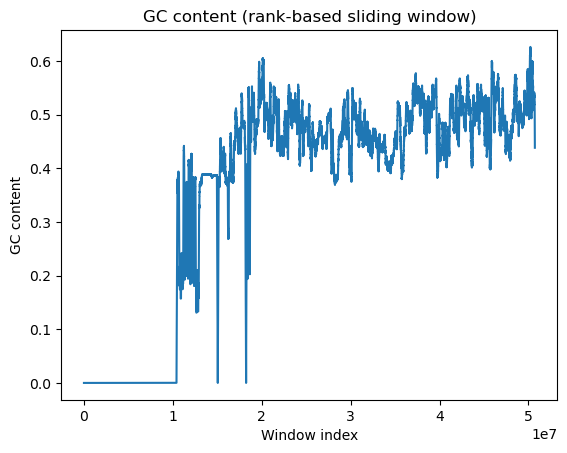

In [189]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(gc_content_rank)
plt.xlabel("Window index")
plt.ylabel("GC content")
plt.title("GC content (rank-based sliding window)")
plt.show()

In [191]:
from pympler import asizeof

In [192]:
asizeof.asizesof(root)

(248533112,)

In [193]:
asizeof.asizesof(genome)

(50818512,)